## 实验6：面向新冠肺炎的社会计算应用 -- 疫情相关中文数据
观察数据发现带有comment的新闻数据是1月到3月8日，在处理数据中发先数据量非常的大，考虑到想要对人们对新闻做感情分析，这次实验的数据就读取了带有comment的数据。
本次实验预期分析：
- 词云展示
- 新闻聚类
- 新闻相关评论情绪  (没有实现，思路是找到一些情感词典，新闻/评论数据中对每条数据的每个单词找到对应的情感，取平均得到这条新闻/评论的情感方向。最后观察对应新闻的情感方向和评论的情感方向）


In [213]:
import json
import pandas as pd
import numpy as np
import datetime
import os
import jieba
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import PIL .Image as image
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
import seaborn as sns; sns.set()

- 在网上找了中文停用词表，stopword用于去掉停用词。
- word_cut用于分词。
- gen_farc用于计算词频。
- top_word更具gen_frac计算出现次数最多的词。

In [158]:
home = 0
path='D:\\tsinghua\\NLP\\' if home else 'C:\\Users\\C5317050\\Desktop\\tsinghua_nlp\\'
stopword = []

class stopword(object):
    def __init__(self,path):
        self.path = path
        with open(self.path, encoding='utf-8') as f:
            self.stop_word = f.read().splitlines()
            self.stop_word_rm_sp = self.stop_word.copy()
            self.stop_word_rm_sp.append(' ')

    def rmstopword(self, strings, wordcloud=1):
        if wordcloud:
            for sw in self.stop_word:
                if sw in strings:
                    strings = strings.replace(sw, '')
        else:
            for sw in self.stop_word_rm_sp:
                while sw in strings:
                    strings.remove(sw)
        return strings

sw = stopword(path + '\\news\\stopword.txt')
#print(sw.stop_word)

def word_cut(corpus,wordcloud=1):
    corpus_cut = []
    for cor in tqdm(corpus):
        cut = jieba.cut(cor)
        cor_cut = ' '.join(cut) if wordcloud else [ word for word in cut ]
        cor_cut = sw.rmstopword(cor_cut,wordcloud)
        corpus_cut.append(cor_cut)
    return corpus_cut


def gen_frac(doc_cut,max_features=None,max_df=1.0,min_df=1):
    cv = CountVectorizer(max_features=max_features, max_df=max_df, min_df=min_df)
    doc_cv = cv.fit_transform(doc_cut)
    return cv, doc_cv

def topword(cv, doc_cv, top=100):
    word_frac = doc_cv.toarray().sum(axis=0)
    top_word = []
    for i in sorted(range(len(word_frac)), key = lambda x:word_frac[x], reverse=True)[0:top]:
        vk = {v:k for k,v in cv.vocabulary_.items()}
        print(i, word_frac[i], vk[i])
        top_word.append(vk[i])
    return top_word

对于新闻数据读取。
观察数据后发现，并不是说有数据都有comment。考虑到人们对于新闻的感情做分析，所以只读取了带有comment的新闻。
通过doc, doc_title, doc_description, doc_keyword, doc_content可以看出，doc_gen函数收集了新闻的标题，描述，关键词，正文。其中doc是将所有的拼接在一起，也是后面主要使用的数据。

In [ ]:
def doc_gen(comment_path, new_path, path, wc=1):
    doc = []
    doc_title = []
    doc_description = []
    doc_keyword = []
    doc_content = []
    for file in os.listdir(path + comment_path):
        if not os.path.isdir(path + comment_path + file):
            with open(path+comment_path+file, 'r',encoding='utf-8') as comment_f, open(path+new_path+file,'r',encoding='utf-8') as new_f:
                comment_data = json.load(comment_f)
                new_data = json.load(new_f)
                #print(len(comment_data))
                for c_d in comment_data:
                    if len(c_d['comment']) == 0:
                        continue
                    time = c_d['time']
                    title = c_d['title']
                    url = c_d['url']
                    comment_num = len(c_d['comment'])
                    comment, area = [],[]
                    for n_d in new_data:
                        if time == n_d['time'] and title == n_d['title'] and url == n_d['url']:
                            doc.append(str(n_d['title']).strip() + ',' + str(n_d['meta']['keyword']).strip() + ',' + str(n_d['meta']['description']).strip() + ',' + str(n_d['meta']['content']).strip())
                            doc_title.append(sw.rmstopword(str(n_d['title'])))
                            doc_keyword.append(sw.rmstopword(str(n_d['meta']['keyword']).strip()))
                            doc_description.append(sw.rmstopword(str(n_d['meta']['description']).strip()))
                            doc_content.append(str(n_d['meta']['content']).strip())
                            '''
                            print('title is : {}'.format(str(n_d['title'])))
                            print('keyword is : {}'.format(n_d['meta']['keyword']))
                            print('description is : {}'.format(n_d['meta']['description']))
                            print('content is : {}'.format(n_d['meta']['content']))

                            comment = [ c['content'] for c in c_d['comment'] ]
                            area = [ c['area'] for c in c_d['comment']]
                            print('comment is {}'.format(comment))
                            print('area is {}'.format(area))
                            df = df.append({ 'time':n_d['time'],'title':n_d['title'],'keyword':n_d['meta']['keyword'],'description':n_d['meta']['description'],'type':n_d['meta']['type'],'content':n_d['meta']['content'],'comment':comment,'comment_area':area,'comment_num':comment_num }, ignore_index=True)
                            '''
                            #doc = word_cut(doc, wordcloud=wc)
                            #doc_title = word_cut(doc_title, wordcloud=wc)
                            #doc_description = word_cut(doc_description, wordcloud=wc)
                            #doc_keyword = word_cut(doc_keyword, wordcloud=wc)
                            #doc_content = word_cut(doc_content, wordcloud=wc)
                            break
    return doc, doc_title, doc_description, doc_keyword, doc_content

针对word2vec模型计算关键词，并没有使用到。

In [ ]:
# 计算关键词
def predict_proba(oword, iword, model):
    iword_vec = model[iword]
    print('iword_vec is {}'.format(iword_vec))
    #oword = model.wv.vocab[oword]
    oword = model.wv[oword]
    print('oword is {}'.format(oword))
    oword_l = model.syn1[oword.point].T
    print('oword_l is {}'.format(oword_l))
    dot = np.dot(iword_vec, oword_l)
    lprob = -sum(np.logaddexp(0, -dot) + oword.code*dot)
    return lprob

from collections import Counter
def keywords(s, model):
    s = [w for w in s if w in model]
    ws = {w:sum([predict_proba(u, w, model) for u in s]) for w in s}
    return Counter(ws).most_common()

In [161]:
home = 0
path='D:\\tsinghua\\NLP\\' if home else 'C:\\Users\\C5317050\\Desktop\\tsinghua_nlp\\'

In [186]:
%%time
# All doc which have comment
comment_path = 'news\\comment\\'
new_path = 'news\\data\\'
doc,doc_title,doc_description, doc_keyword, doc_content = doc_gen(comment_path, new_path, path)#, wc=0)
#doc = doc_gen(comment_path, new_path, path)

Wall time: 2min 16s


In [190]:
doc_keyword[3]

'中新纬 全国委'

对获取的数据进行观察

In [217]:
print('doc is {},{}'.format(len(doc), doc[0:10]))
print('doc title is {},{}'.format(len(doc_title), doc_title[0:10]))
print('doc_description is {},{}'.format(len(doc_description),doc_description[0:10]))
print('doc keyword is {},{}'.format(len(doc_keyword),doc_keyword[0:10]))
print('doc content is {},{}'.format(len(doc_content),doc_content[0:10]))

doc is 59364,['特朗普税收优惠政策对美国贫困地区房价影响近乎为零,[],特朗普税收优惠政策对美国贫困地区房价影响近乎为零,新浪美股1月1日讯 美国总统特朗普曾经强调，被新减税政策选中的低收入地区房价“飙升”，证明他的政府实施的政策正在美国一些最困苦的社区促进增长预期。 新的研究对此提出了质疑。根据全国经济研究所本周发布的一篇工作论文，“机遇区”房价受到的影响微乎其微，“统计学上近乎为零”。这篇工作论文的作者是哈佛大学的Jiafeng Chen、Edward Glaeser和布鲁金斯学会的David Wessel。 研究人员使用来自美国联邦住房金融局的重复销售数据，对这些区域内的房价进行了自己的评估，并将其与广泛报道的2019年早些时候的Zillow分析进行了比较。Zillow的研究发现，政府2018年界定的8700多个“机遇区”房价上涨了25%，而合乎条件但未获界定的地区房价上涨了8.4%，全国其他地区房价上涨了2.5%。 最新发现肯定会使有关机遇区激励措施是否值得让美国政府放弃潜在数十亿美元税收的辩论变得更加复杂。自特朗普2017年底将其签署为法律以来，批评人士表示这些福利已被用于奖赏从佛罗里达到俄勒冈的豪宅开发，而支持者则称这些措施正在刺激从阿拉巴马到宾夕法尼亚的振兴努力。 为什么两项研究之间存在差异？全国经济研究所论文的作者指出，Zillow使用“不透明算法”来计算价格，而不是实际的销售数据。他们写道，Zillow的研究没有剔除此前的房价趋势，因而可能夸大了减税措施的影响。 “这项计划的希望是促进社区复兴，”Chen、Galeser和Wessel写道。“但是，我们发现早期没什么证据支持这个观点。” Zillow报告作者、研究员Alexander Casey在电子邮件声明中说，Zillow发现价格早早上涨，“并非认定潜在价值是否发生变化或者变化是否长期保持。” “我们发现的售价立即飙升，和他们发现的整体并不影响房价，二者不一定是矛盾的，”他说。“正如研究人员明确指出的那样，我们的方法可以轻松反映当前市况，而不是实际潜在价值的任何变化。” 责任编辑：张宁', "林郑：香港这支卓越警队是特区政府最大资产之一,['林郑月娥'],一天，林郑在警总告诉警队：相信正义站在我们一边！林郑月娥说，香港这支卓越的警队，是特区政府最大资产之一。香港“修例风波”持续半年

In [7]:
%%time
# word cut for word cloud
doc_cut = word_cut(doc)
print(len(doc_cut))
print(doc_cut[0:10])

  0%|          | 0/59364 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\C5317050\AppData\Local\Temp\jieba.cache
Loading model cost 1.810 seconds.
Prefix dict has been built successfully.
100%|██████████| 59364/59364 [11:25<00:00, 86.59it/s] 

59364
['特朗普 税收 优惠政策  美国 贫困区 房价 影响        特朗普 税收 优惠政策  美国 贫困区 房价 影响     新浪 美股  月  日讯   美国 总统 特朗普     新 减税 政策 选中  低收入 区 房价  飙升   证明   政府 实施  政策  美国   困苦  社区  增长 预期    新  研究  提  质疑  根 全国 济 研究 周 发布  篇 工作 文   机遇 区  房价 受  影响 微微   统计学       篇 工作 文  作  佛学  Jiafeng   Cn  Edwa   Glaeser  布鲁金斯 学  David   Wessel    研究 员   美国联邦 住房 金融 局  重复 销售 数    区域   房价     评估       报道   年 早  Zillow 分析     Zillow  研究 发现  政府  年 界     机遇 区  房价 涨     合 条件  未获 界  区 房价 涨    全国  区 房价 涨      新 发现 肯    机遇 区 激励 措施 否 值  美国政府 放弃 潜 数十亿美元 税收  辩 变     特朗普  年底   签署  法律   批评 士   福利    奖赏  佛罗里达  俄勒冈  豪宅 开发   支持  称  措施  刺激  拉马  宾夕法尼亚  振兴 努力     两项 研究 间  差异  全国 济 研究 文  作 指  Zillow    透明 算法   计算 价格      销售 数   写道  Zillow  研究  剔 前  房价 趋势    夸  减税 措施  影响     项 计划  希   社区 复兴   Cn  Galeser  Wessel 写道      发现 早期  证 支持  观点     Zillow 报告 作  研究员 ler   Cey  电子邮件 声明 中说  Zillow 发现 价格 早早 涨   非 认 潜 价值 否 发生变化  变化 否 长期       发现  售价  飙升    发现  整体   影响 房价      矛盾     说   正 研究 员 指      法  轻松  前 市况     潜 价值   变化     责编辑  张', '林郑  香港 支 卓越 警队  特区政府  资产 

做词云展示

In [ ]:
%%time
wc_doc = ' '.join(doc_cut)
wc = WordCloud(font_path='C:\\Windows\\WinSxS\\amd64_microsoft-windows-font-truetype-simhei_31bf3856ad364e35_10.0.19041.1_none_aa18c3e2137269cf\\simhei.ttf').generate(wc_doc)
#wc = WordCloud().generate(wc_doc)
image_produce = wc.to_image()

In [ ]:
image_produce.show()

(-0.5, 399.5, 199.5, -0.5)

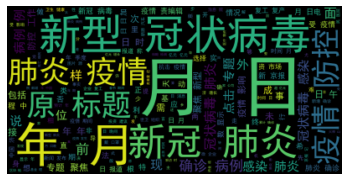

In [218]:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [34]:
%%time
path='D:\\tsinghua\\NLP\\' if home else 'C:\\Users\\C5317050\\Desktop\\tsinghua_nlp\\'
print(type(doc_cut))
f=open(path+'news\\doc_cut.txt','w',encoding='utf-8')
f.write('\n'.join(doc_cut))
f.close()

<class 'list'>


计算词频最多的词语。

In [ ]:
%%time
cv, doc_cv = gen_frac(doc_cut,max_features=10000)
top_word = topword(cv, doc_cv)

对词频最多的词进行聚类

In [ ]:
top_word_vec = cv.transform(top_word)
print(top_word_vec.shape)
clusters_topword = KMeans(n_clusters=10, random_state=0).fit_predict(top_word_vec)
print(clusters_topword)

In [211]:
classes_topword = {}
for i in range(10):
    classes_topword[i] = []
    class_i = np.where(clusters_topword == i)[0]
    classes_topword[i] = [ top_word[ci] for ci in class_i ]

In [212]:
print(classes_topword)

{0: ['疫情', '中国', '公司', '肺炎', '市场', '企业', '工作', '新型', '武汉', '防控', '冠状病毒', '亿元', '影响', '新冠', '口罩', '病例', '责编辑', '国家', '医院', '时间', '情况', '确诊', '发布', '相关', '感染', '增长', '标题', '全球', '病毒', '资金', '产品', '提供', '报道', '基金', '信息', '显示', '服务', '风险', '生产', '支持', '政策', '科技', '伊朗', '研究', '业务', '包括', '消费', '集团', '全国', '物资', '需求', '北京', '技术', '复工', '机构', '发现', '期间', '万元', '措施', '政府', '医疗', '报告', '持续', '平台', '新增', '增加', '价格', '项目', '发生', '关注', '预计', '规模', '汽车', '国际', '交易', '股份', '银行', '媒体', '城市', '销售', '计划', '组织', '保障', '新闻', '指数', '健康', '季度', '点击', '特斯拉', '预期', '专题'], 1: ['消息'], 2: ['证券'], 3: ['员工'], 4: ['行业'], 5: ['湖北'], 6: ['累计'], 7: ['发展'], 8: ['投资'], 9: ['美国']}


In [10]:
%%time
# word cut for word2vec
doc_cut_nowc = word_cut(doc,wordcloud=0)
print(len(doc_cut_nowc))
print(doc_cut_nowc[0:10])

100%|██████████| 59364/59364 [1:00:17<00:00, 16.41it/s] 

59364
[['特朗普', '税收', '优惠政策', '美国', '贫困地区', '房价', '影响', '近乎', '特朗普', '税收', '优惠政策', '美国', '贫困地区', '房价', '影响', '近乎', '新浪', '美股', '月', '日讯', '美国', '总统', '特朗普', '新', '减税', '政策', '选中', '低收入', '地区', '房价', '飙升', '证明', '政府', '实施', '政策', '美国', '困苦', '社区', '增长', '预期', '新', '研究', '对此', '提出', '质疑', '全国', '经济', '研究所', '本周', '发布', '一篇', '工作', '论文', '机遇', '区', '房价', '影响', '微乎其微', '统计学', '近乎', '这篇', '工作', '论文', '作者', '哈佛大学', 'Jiafeng', 'Chen', 'Edward', 'Glaeser', '布鲁金斯', '学会', 'David', 'Wessel', '研究', '人员', '美国联邦', '住房', '金融', '局', '重复', '销售', '数据', '区域', '房价', '评估', '报道', '2019', '年', '早些时候', 'Zillow', '分析', 'Zillow', '研究', '发现', '政府', '2018', '年', '界定', '8700', '多个', '机遇', '区', '房价', '上涨', '25%', '合乎', '条件', '未获', '界定', '地区', '房价', '上涨', '8.4%', '全国', '地区', '房价', '上涨', '2.5%', '最新', '发现', '肯定', '机遇', '区', '激励', '措施', '值得', '美国政府', '放弃', '潜在', '数十亿美元', '税收', '辩论', '变得', '特朗普', '2017', '年底', '签署', '法律', '批评', '人士', '福利', '用于', '奖赏', '佛罗里达', '俄勒冈', '豪宅', '开发', '支持者', '称', '措施', '刺激', '阿拉巴马', '宾夕法尼亚', '

In [35]:
%%time
doc_f = open('doc_cut_nowc.txt', 'wb')
pickle.dump(doc_cut_nowc, doc_f)
doc_f.close()

Wall time: 11.9 s


In [37]:
'''
doc_f = open('doc_cut_nowc.txt','rb')
doc_cut_nowc = pickle.load(doc_f)
doc_f.close()
print(doc_cut_nowc[0:10])
'''

[['特朗普', '税收', '优惠政策', '美国', '贫困地区', '房价', '影响', '近乎', '特朗普', '税收', '优惠政策', '美国', '贫困地区', '房价', '影响', '近乎', '新浪', '美股', '月', '日讯', '美国', '总统', '特朗普', '新', '减税', '政策', '选中', '低收入', '地区', '房价', '飙升', '证明', '政府', '实施', '政策', '美国', '困苦', '社区', '增长', '预期', '新', '研究', '对此', '提出', '质疑', '全国', '经济', '研究所', '本周', '发布', '一篇', '工作', '论文', '机遇', '区', '房价', '影响', '微乎其微', '统计学', '近乎', '这篇', '工作', '论文', '作者', '哈佛大学', 'Jiafeng', 'Chen', 'Edward', 'Glaeser', '布鲁金斯', '学会', 'David', 'Wessel', '研究', '人员', '美国联邦', '住房', '金融', '局', '重复', '销售', '数据', '区域', '房价', '评估', '报道', '2019', '年', '早些时候', 'Zillow', '分析', 'Zillow', '研究', '发现', '政府', '2018', '年', '界定', '8700', '多个', '机遇', '区', '房价', '上涨', '25%', '合乎', '条件', '未获', '界定', '地区', '房价', '上涨', '8.4%', '全国', '地区', '房价', '上涨', '2.5%', '最新', '发现', '肯定', '机遇', '区', '激励', '措施', '值得', '美国政府', '放弃', '潜在', '数十亿美元', '税收', '辩论', '变得', '特朗普', '2017', '年底', '签署', '法律', '批评', '人士', '福利', '用于', '奖赏', '佛罗里达', '俄勒冈', '豪宅', '开发', '支持者', '称', '措施', '刺激', '阿拉巴马', '宾夕法尼亚', '振兴', '

使用doc2vec词向量模型

In [ ]:
%%time
#doc_model = Word2Vec(doc_cut_nowc, vector_size=1000, window=5, min_count=1, workers=8)
doc_tag = [TaggedDocument(doc,[i]) for i,doc in enumerate(doc_cut_nowc)]

doc_model = Doc2Vec(doc_tag, vector_size=1000, window=4, min_count=1, workers=8)

In [72]:
len(doc_tag)

59364

数据观察

In [ ]:
%%time
doc_vectors = doc_model.docvecs.vectors
print(doc_vectors.shape)
a = doc_model.docvecs.most_similar(1)
print('a is {}'.format(a))
b = doc_model.docvecs[1]
c = doc_model.wv['特朗普']
d = doc_model.wv.get_vector('特朗普')
print('c is {}'.format(c[0:30]))
print('d is {}'.format(d[0:30]))
print(doc_model.similarity_unseen_docs(['特朗普'], ['美国'],steps=10 ))
e = doc_model.dv[59347]
print('e is {}'.format(e[0:30]))

In [219]:
'''
%%time
# cal the keyword by doc2vec
doc_keyword_d2c = []
for doc in doc_cut:
    doc_keyword_d2c.append(keywords(doc, doc_model))

print(doc_keyword_d2c[0:10])
'''

'\n%%time\n# cal the keyword by doc2vec\ndoc_keyword_d2c = []\nfor doc in doc_cut:\n    doc_keyword_d2c.append(keywords(doc, doc_model))\n'

对doc2vec进行聚类。

In [ ]:
%%time
clusters_d2v = KMeans(n_clusters=10, random_state=0).fit_predict(doc_vectors)

In [154]:
print(clusters_d2v[0:200])

[5 5 3 6 7 7 7 6 5 6 4 9 6 5 7 8 3 1 3 3 6 3 6 3 3 3 8 6 1 5 2 4 7 5 5 2 3
 8 8 5 3 3 8 5 1 5 5 7 1 7 3 7 1 8 8 0 6 6 0 4 6 6 8 5 5 5 8 8 8 0 8 5 6 3
 6 1 5 5 5 8 7 5 8 5 6 6 7 2 6 5 1 5 9 3 5 7 5 5 5 8 0 8 5 5 2 2 2 5 5 5 0
 0 6 6 8 8 5 5 5 7 5 5 5 5 0 8 8 8 8 8 5 8 8 5 5 5 8 5 3 5 8 3 5 5 4 5 6 5
 5 5 5 8 1 5 8 5 5 2 5 5 5 5 5 5 5 5 4 9 9 5 7 3 8 4 8 6 8 5 5 5 8 8 5 5 8
 5 5 5 5 2 1 4 8 5 2 8 1 8 5 5]


In [191]:
%%time
d2v_classes = {}
for i in range(10):
    d2v_classes[i] = []
    class_i = np.where(clusters_d2v == i)[0]
    d2v_classes[i] = [doc_keyword[ci] for ci in class_i]

Wall time: 66 ms


In [194]:
print(d2v_classes[0])
print(type(d2v_classes[0][0]))
print(len(d2v_classes[0]))

['正防卫', '网络投票 刷票', '春运 抢票软件', '微信支付 财付通', '房屋开裂', '蒙羊', '暴力', '春运火车票 火车票', '雇凶', '通缉犯', '酒鬼酒', '酒鬼酒', '勇救', '暴力', '贵州', '菜刀', '赛马 海南', '涉嫌犯罪 违纪', '盗刷', '硫化氢', '国土资源 怀柔区', '财政部', '', '身亡 车祸', '家属院', '箱', '财富 网络贷平台', '财富 网络贷平台', '浙江', '砸 暴力', '游行 湾仔', '游行 湾仔', '宝马 新源汽车', '宝马 新源汽车', '宝马 新源汽车', '景区', '硬币 航班', '弹窗 广告 安权', '员伤亡 消防员', '', '雷克萨斯 汽车行业', '选举', '纳税 税务机关', '香港警', '殴', '香港 港警 暴徒', '砸', '湾仔 中环', 'QQ号 诈骗', '弹窗', '户口 死亡', '涉事', '诈骗', '深圳 司机 猝死', '调查报告', '海联金汇 央行', '英雄', '', '肋骨骨折', '火车票', '诈骗团伙', '农民工', '殴', '买房 复婚', '游行', '', '', '', '市场监督 野生动物', '摊贩 城', '拍卖', '淘宝', '酒驾 交警', '铁', '雪乡', '诈骗 孩子', '', '', '身亡 仪征', '开庭 刺死滴滴司机', '海南', '酒驾 违法 首', '高法', '', '反垄断执法机构 市场监', '香港警 旺角', '春运火车票 抢票平台', '澎湃新闻', '劫持', '菜刀', '开庭', '开庭 滴滴 司机遇害', '医药 香雪制药', '医药 香雪制药', '意稿 市场监', '澎湃新闻 开发区', '卫龙辣条 食物中毒', '救援队', '', '非法营运 恶势力', '住建局 云南', '住建局 云南 廉租房', '市场监督 野生动物 武汉 湖北', '疫情', '嫌疑', '彘 杀妻 男尸', '', '淮南', '摔伤', '仪征 拆迁', '杀案', '死刑', '辱华', '讯 裁员 暴力裁员', 'ETC卡', '男家', '暴力', '坠亡 男童', '嫌疑 开庭', '黑', '落马', '', '火灾 消

使用PCA降维，并建图。
虽然图画了出来，但是很难体现出每个类别的属性。
有通过提取分类后的keyword和title来观察类别属性，但是效果不好。
同样也考虑通过word2vec来提取关键词体现类别属性。同样失败了。

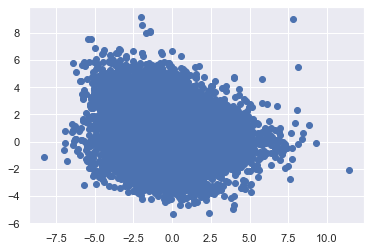

In [220]:
# PCA 降维
pca = PCA(n_components=2)
x = pca.fit_transform(doc_vectors)
plt.scatter(x[:, 0], x[:, 1],marker='o')
plt.show()

No handles with labels found to put in legend.


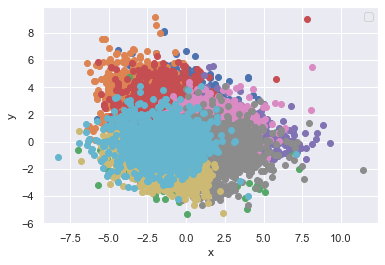

Wall time: 1.3 s


In [216]:
%%time
for i in range(10):
    plt.scatter(x[clusters_d2v==i,0],x[clusters_d2v==i,1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

对词频得到的词向量进行聚类,但是效果并不好。

In [ ]:
%%time
#print(doc_cv[0:10])
clusters_tf = KMeans(n_clusters=10, random_state=0).fit_predict(doc_cv.toarray())

In [203]:
np.where(clusters_tf==4)

(array([    0,     1,     2, ..., 59359, 59360, 59361], dtype=int64),)

In [196]:
%%time
tf_classes = {}
for i in range(10):
    tf_classes[i] = []
    class_i = np.where(clusters_tf == i)[0]
    tf_classes[i] = [ doc_keyword[ci] for ci in class_i ]

Wall time: 123 ms


In [222]:
print(tf_classes[7])

['资产配置 信债', '资市场 证券法', '', '', '', '', '股指期货 股指期权', '', '贝莱德 私募 股票型基金 私募基金', '', '', '补库存 PPI', '', '基金净值 主题基金', '', '反垄断执法机构 市场监', '', '', '股票 基金 黄金 美元 特币', '公募基金 股市场', '指数基金 基金理', '股基 股票型基金', '资市场 央企 创业板', '', '资市场 央企 创业板', '博时 公募基金', '孙正义 WeWk', '孙正义 WeWk 基金', '', '孙正义 WeWk', '孙正义 WeWk', '开发商', '商品 贵金属 展', '', '股票 基金 黄金 美元 特币', '港股 恒生指数', '', '新兴市场 贝莱德', '公募基金 新板', '电商 反垄断法', '公募 基金业', '公募 基金业', '', '国际金融报 指数基金 建信', '', '', '保监 机构', '', '', '', '证综指 券商 成交额', '券商 证券法', '', '证券法 IPO', '', '姜超 海通证券', '避险资产 美国制造业 金价', '', '魏杰 金融风险', '股票 基金 黄金 美元 特币', '', '港股 天弘基金', '私募 基金理', '', '网络文化', '', '', '基金理 公募', '', '私募 私募基金', '混合型基金 混合基金', '产业链 集成电路产业', '', '', '软银集团 WeWk', '', '', '', '', '中信期货', '浦银安盛 国际金融报', '购车 北汽集团', '公募基金 股票型基金', '基金 原油', '公募基金 认购', '东海证券 券商资', '制造业 工业增加值', '', '投摩根 鼠仓', '刘正男 科技领域 创业', '东海证券 券商资', '浦银安盛 国际金融报', '网络文化', '', '', '股票 基金 美元 黄金 特币', '', '', '', '', '', '', '', '中国证券报 股市场', '', '金融危机 资产负债表', '', '', '', '', '阎庆民 资市场', '资市场 红周刊 李迅雷', '', '陆 创业', '', '', '', '',

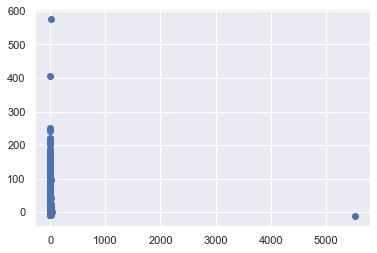

In [223]:
pca_tf = PCA(n_components=2)
x_cv = pca.fit_transform(doc_cv.toarray())
plt.scatter(x_cv[:, 0], x_cv[:, 1],marker='o')
plt.show()

No handles with labels found to put in legend.


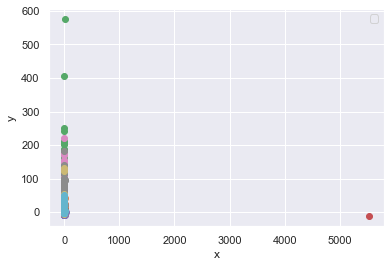

Wall time: 1.34 s


In [225]:
%%time
for i in range(10):
    plt.scatter(x_cv[clusters_tf==i,0],x_cv[clusters_tf==i,1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
%%time
for i in range(10):
    plt.scatter(x[clusters_d2v==i,0],x[clusters_d2v==i,1])
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

对一月的数据进行分析

In [ ]:
%%time
# doc which have comment in Jan
Jan_comment_path = 'news\\comment\\Jan\\'
new_path = 'news\\data\\'
doc_Jan = doc_gen(Jan_comment_path, new_path, path)

In [12]:
%%time
# word cut for word cloud Jan
Jan_doc_cut = word_cut(doc_Jan)
print(len(Jan_doc_cut))
Jan_doc_cut[0:10]


100%|██████████| 25346/25346 [04:09<00:00, 101.49it/s]

25346
0:04:09.736144


In [13]:
%%time
wc_Jan_doc = ' '.join(Jan_doc_cut)
jan_wc = WordCloud(font_path='C:\\Windows\\WinSxS\\amd64_microsoft-windows-font-truetype-simhei_31bf3856ad364e35_10.0.19041.1_none_aa18c3e2137269cf\\simhei.ttf').generate(wc_Jan_doc)
jan_image_produce = jan_wc.to_image()

In [ ]:
jan_image_produce.show()

(-0.5, 399.5, 199.5, -0.5)

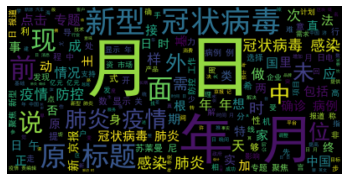

In [228]:
plt.imshow(jan_wc, interpolation='bilinear')
plt.axis("off")

In [14]:
%%time
Jan_cv, Jan_doc_cv = gen_frac(Jan_doc_cut,max_features=10000)
Jan_top_word = topword(Jan_cv, Jan_doc_cv)


533 50132 中国
1395 47995 公司
3581 37374 市场
7654 37026 美国
6834 36901 疫情
4431 29060 投资
930 25212 企业
873 24202 亿元
5743 24167 武汉
941 23924 伊朗
5103 23855 新型
3538 23407 工作
7811 22211 肺炎
1528 21735 冠状病毒
2282 21285 发展
8519 21174 责编辑
2712 20178 国家
2906 18307 增长
5246 18216 时间
4494 16988 报道
5574 16578 标题
4148 16479 情况
2290 16403 发布
6971 16011 相关
832 14910 产品
8100 14715 行业
5308 14585 显示
4202 14383 感染
3964 14304 影响
2006 14301 医院
1161 14243 信息
2861 13798 基金
2395 13470 口罩
9402 13353 防控
4747 12941 提供
1365 12886 全球
8604 12833 资金
319 12641 万元
6846 11987 病例
9525 11915 集团
4394 11787 技术
5371 11645 服务
7180 11577 科技
2308 11568 发现
6165 11508 消费
9722 11473 风险
1933 11303 包括
398 11215 业务
1947 11182 北京
5425 10884 机构
7062 10883 研究
921 10413 价格
6155 10278 消息
3649 10192 平台
2755 10073 国际
4480 10064 报告
4586 10054 持续
4851 9904 支持
1351 9880 全国
9630 9869 项目
9283 9805 银行
6525 9747 特朗普
4942 9655 政府
5907 9632 汽车
4953 9447 政策
3155 9444 媒体
2310 9404 发生
2888 9362 增加
794 9249 交易
9664 9179 预计
1452 9125 关注
8213 8919 规模
2828 8860 城市

In [15]:
%%time
# word cut for word2vec Jan
Jan_doc_cut_nowc = word_cut(doc_Jan,wordcloud=0)
print(len(Jan_doc_cut_nowc))
Jan_doc_cut_nowc[0:10]


100%|██████████| 25346/25346 [17:56<00:00, 23.55it/s] 

25346
0:17:56.303458


对于二月数据进行分析

In [ ]:
%%time
# doc which have comment in Feb
Feb_comment_path = 'news\\comment\\Feb\\'
new_path = 'news\\data\\'
doc_Feb = doc_gen(Feb_comment_path, new_path, path)

In [17]:
%%time
# word cut for word cloud Feb
Feb_doc_cut = word_cut(doc_Feb)
print(len(Feb_doc_cut))
Feb_doc_cut[0:10]

100%|██████████| 26721/26721 [05:13<00:00, 85.16it/s] 

26721
0:05:13.766130


In [18]:
%%time
wc_Feb_doc = ' '.join(Feb_doc_cut)
feb_wc = WordCloud(font_path='C:\\Windows\\WinSxS\\amd64_microsoft-windows-font-truetype-simhei_31bf3856ad364e35_10.0.19041.1_none_aa18c3e2137269cf\\simhei.ttf').generate(wc_Feb_doc)
feb_image_produce = feb_wc.to_image()

In [ ]:
feb_image_produce.show()

(-0.5, 399.5, 199.5, -0.5)

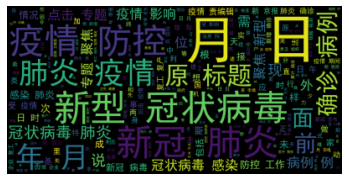

In [226]:
plt.imshow(feb_wc, interpolation='bilinear')
plt.axis("off")

In [19]:
%%time

Feb_cv, Feb_doc_cv = gen_frac(Feb_doc_cut,max_features=10000)
Feb_top_word = topword(Feb_cv, Feb_doc_cv)


6853 134319 疫情
7841 57874 肺炎
962 53239 企业
584 52905 中国
1452 49146 公司
3662 39675 市场
9401 39144 防控
5129 38417 新冠
3615 34073 工作
4020 34033 影响
1584 33071 冠状病毒
2448 32246 口罩
5138 32190 新型
5781 31554 武汉
6868 31179 病例
4484 28819 投资
7127 28386 确诊
2062 27625 医院
901 26184 亿元
7683 24684 美国
6884 24060 病毒
4258 23854 感染
4212 22767 情况
8562 22695 责编辑
2346 21747 发布
5284 20961 时间
2789 20381 国家
7008 20334 相关
8132 20107 行业
3009 19812 复工
6711 19248 生产
5609 17638 标题
6532 17545 物资
2340 17377 发展
4800 16986 提供
8638 16905 资金
4898 16761 支持
2976 16550 增长
5412 16111 服务
6311 15634 湖北
1417 15474 全球
4997 15040 政策
863 15028 产品
9726 14615 风险
7097 14497 研究
5448 14324 期间
4795 14306 措施
5140 14251 新增
2048 14086 医疗
9556 14066 需求
1188 13888 信息
1400 13806 全国
7215 13605 科技
5342 13440 显示
4552 13433 报道
2930 13412 基金
448 13086 业务
1975 12857 包括
2585 12484 员工
1989 11911 北京
1175 11757 保障
9531 11557 集团
4988 11255 政府
6190 11189 消费
5988 11089 治疗
2958 10983 增加
6177 10801 消息
4539 10789 报告
4451 10775 技术
2362 10762 发现
7817 10753 股份
7462 10

In [20]:
%%time
# word cut for word2vec Feb
Feb_doc_cut_nowc = word_cut(doc_Feb,wordcloud=0)
print(len(Feb_doc_cut_nowc))
Feb_doc_cut_nowc[0:10]

100%|██████████| 26721/26721 [20:02<00:00, 22.23it/s]  

26721
0:20:02.127744


三月数据分析

In [ ]:
%%time
# doc which have comment in Mar
Mar_comment_path = 'news\\comment\\Mar\\'
new_path = 'news\\data\\'
doc_Mar = doc_gen(Mar_comment_path, new_path, path)

In [22]:
%%time
# word cut for word cloud Mar
Mar_doc_cut = word_cut(doc_Mar)#,wordcloud=0)
print(len(Mar_doc_cut))
Mar_doc_cut[0:10]

100%|██████████| 7297/7297 [01:24<00:00, 86.50it/s] 

7297
0:01:24.357745


In [23]:
%%time
wc_Mar_doc = ' '.join(Mar_doc_cut)
mar_wc = WordCloud(font_path='C:\\Windows\\WinSxS\\amd64_microsoft-windows-font-truetype-simhei_31bf3856ad364e35_10.0.19041.1_none_aa18c3e2137269cf\\simhei.ttf').generate(wc_Mar_doc)
mar_image_produce = mar_wc.to_image()

In [ ]:
mar_image_produce.show()

(-0.5, 399.5, 199.5, -0.5)

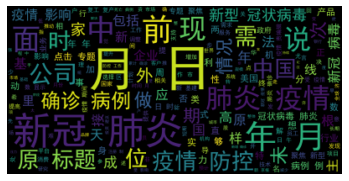

In [229]:
plt.imshow(mar_wc, interpolation='bilinear')
plt.axis("off")

In [24]:
%%time
Mar_cv, Mar_doc_cv = gen_frac(Mar_doc_cut,max_features=10000)
Mar_top_word = topword(Mar_cv, Mar_doc_cv)


6844 33040 疫情
600 17592 中国
1480 16590 公司
3667 16232 市场
5159 16208 新冠
7837 16039 肺炎
4503 13421 投资
991 13001 企业
7674 12028 美国
4051 10160 影响
6858 9120 病例
1447 8936 全球
926 8369 亿元
3610 7906 工作
7102 7765 确诊
8113 7072 行业
9391 6913 防控
2354 6833 发展
2778 6794 国家
2464 6707 口罩
5307 6657 时间
2929 6485 基金
4232 6443 情况
5025 6302 政策
9730 6249 风险
8521 6123 责编辑
2362 6050 发布
2976 5922 增长
6983 5837 相关
6870 5827 病毒
8611 5465 资金
889 5100 产品
7189 5100 科技
3016 4966 复工
9456 4895 降息
6170 4843 消费
468 4791 业务
5427 4759 服务
4818 4669 提供
5362 4656 显示
4924 4628 支持
5613 4565 标题
1226 4551 信息
9556 4541 需求
6686 4495 生产
5787 4373 武汉
1621 4315 冠状病毒
2013 4302 包括
7071 4197 研究
5169 4168 新型
5172 4112 新增
7707 4098 美联储
2087 4077 医院
4569 4077 报道
9635 4026 项目
5483 4007 机构
9528 3937 集团
2075 3921 医疗
4661 3914 持续
4681 3869 指数
8224 3849 规模
4813 3721 措施
2581 3685 员工
4286 3674 感染
9658 3667 预期
3902 3624 建设
8328 3615 证券
9671 3608 预计
4468 3575 技术
8280 3569 计划
5017 3533 政府
9300 3532 销售
1813 3519 利率
7448 3481 累计
5462 3448 期间
980 3425 价格
3738

In [25]:
%%time
# word cut for word2vec Mar
Mar_doc_cut_nowc = word_cut(doc_Mar,wordcloud=0)
print(len(Mar_doc_cut_nowc))
Mar_doc_cut_nowc[0:10]

100%|██████████| 7297/7297 [06:11<00:00, 19.65it/s] 

7297
0:06:11.355800


In [26]:
print(Mar_doc_cut_nowc[0:10])

[['黄', '女士', '进京', '追踪', '挺', '可怜', '一家人', '黄', '女士', '新冠', '肺炎', '进京', '追踪', '挺', '可怜', '一家人', '黄', '女士', '进京', '事件', '持续', '发酵', '武汉', '疫情', '严控', '之下', '一位', '黄姓', '女士', '武汉', '女子监狱', '刑满释放', '家属', '驾车', '接到', '月', '22', '日', '凌晨', '时', '北京', '月', '23', '日', '19', '00', '黄', '女士', '发热', '急救车', '转运', '东城区', '普仁', '医院', '原', '标题', '黄', '女士', '进京', '追踪', '挺', '可怜', '一家人', '黄', '女士', '进京', '事件', '持续', '发酵', '武汉', '疫情', '严控', '之下', '一位', '黄姓', '女士', '武汉', '女子监狱', '刑满释放', '家属', '驾车', '接到', '月', '22', '日', '凌晨', '时', '北京', '月', '23', '日', '19', '00', '黄', '女士', '发热', '急救车', '转运', '东城区', '普仁', '医院', '第二天', '确认', '新冠', '肺炎', '确诊', '病例', '武汉', '封城', '尚未', '解除', '北京', '防疫', '黄', '女士', '武汉', '进', '北京', '一时间', '黄', '女士', '身份', '猜想', '乱花渐欲迷人眼', '有人', '猜', '国美', '电器', '创始人', '黄光裕', '二妹', '有人', '猜', '落马', '高官', '家属', '谜底', '很快', '揭晓', '月', '27', '日', '上午', '11', '43', '分', '时代', '周报', '新', '媒体', '独家报道', '黄', '女士', '身份', '详情请', '独家', '武汉', '跑', '回', '北京', '黄', '女士', '竟是', '黄', '女士', '本名', '黄登英', '19

In [113]:
#doc_tv
# strip()
# 任务 词频->词云。--sklearn 词频使用
# 任务 聚类 -> 文档相似度
# 任务 情感 -> 情感词典
# 任务 news:comment 人们对news的情感反应

a = ['a','b','c','d','e','a','b']
b = 'abcde'
c = ['c','d','e','a','c','d']
a.remove('a')
for cs in c:
    print(c, cs)
    if cs in a:
        c.remove(cs)
        print(c)
print(c)

['c', 'd', 'e', 'a', 'c', 'd'] c
['d', 'e', 'a', 'c', 'd']
['d', 'e', 'a', 'c', 'd'] e
['d', 'a', 'c', 'd']
['d', 'a', 'c', 'd'] c
['d', 'a', 'd']
['d', 'a', 'd']
